# Scikit Learn Benzene Price Forecasting

## 0.0 Notes and Explainations

This notebook uses SQL to query::
* lyb-sql-devdacore-002.5bff9fcb8330.database.windows.net 
    * To extract the information contained in the t-code ZMRRELPO
* lyb-sql-prddacore-002.bed79ae4ef8b.database.windows.net
    * To extract ZEMA IHS data
    * To extract ZEMA ICIS data

### 0.1 Environment setup

This workbook utilizes the py37_benzene environment which can be installed via the Anaconda Prompt from your local repo sync by running:
> conda env create -f py37_benzene.yml

This .yml file is stored in the root scripts directory

## 1.0 Prepare Workspace

### 1.1 Import Standard Libraries and configure runtime parameters

In [1]:
##
# Import Basic Python DS Libraries 
import pandas as pd     # Standard data science package
import numpy as np      # Additional numerical functions
#import dtale
##
# Import Advanced Python DS Libraries
import missingno as msno    # Missing value toolbox
#from pandas_profiling import ProfileReport     # Integrated/deep reporting, resource intensive
from statsmodels.tsa.stattools import adfuller  # Statistical test for stationary data

##
# Import Database Connection Libraries
#import pyodbc           # Database connector

##
# Import Plotting Libraries
import matplotlib.pyplot as plt                # Full featured plotting toolbox
plt.rcParams['figure.figsize'] = (25,8)
#import plotly.graph_objects as go               #Plotly GO toolbox
import plotly.express as px                    # Plotly Express plotting toolbox
import plotly.io as pio                        # Addtional Controls for plotly to allow visuals within VSCode Notebook
#import seaborn as sns       # Seaborn plotting toolbox

##
# Import Operating System Interface Libraries
import os       # operating system interface
import sys
import calendar
import datetime as dt
#from datetime import datetime, timedelta, date

##
# Import File Format Libraries
#import pyarrow.feather as feather       # Advanced datasource import/export toolbox (Apache Parquet)

##
# Import ML and Forecasting Libraries
#from scipy import interpolate
#from sklearn import metrics     # Metrics for sklearn ML models
from sklearn.ensemble import RandomForestRegressor # ML Model package
#from sklearn.tree import DecisionTreeRegressor  # ML Model package
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sklearn.model_selection import RandomizedSearchCV
#from prophet import Prophet

##
# Setup packages for sending messages
import requests
import json


In [2]:
# Configure Libraries
pio.renderers.default = "notebook_connected" # Configure plotly to print within VSCode environment
#pio.renderers.default = "vscode"


In [3]:
# Configure Run Environment
AllLPC = True # Used in the "Deal with non-Stationary data" step to ensure that e take the Percent Change for every column and not just those that are non-stationary

### 1.2 Import Custom Functions

In [4]:
# Define location for custom functions
module_path = os.path.abspath(os.path.join('../Functions'))

# Verify it's accessible for loading
if (module_path not in sys.path) & (os.path.isdir(module_path)):
    sys.path.append(module_path)
    print('Added', module_path, 'to system paths')

elif (module_path in sys.path) & (os.path.isdir(module_path)):
    print(module_path, 'ready to be used for import')

else:
    print(module_path, 'is not a valid path')

# Import Custom Functions
try: from multi_plot import *; print('Loaded multiplot')
except: print('failed to load multi_plot')

try: from StationaryTools import *; print('Loaded StationaryTools')
except: print('Failed to load StationaryTools')

try: from RegressionTools import *; print('Loaded RegressionTools')
except: print('Failed to load RegressionTools')

try: from NaiveForecasting import *; print('Loaded NaiveTools')
except: print('Failed to load NaiveTools')

try: from ModelingTools import *; print("Loaded ModelingTools")
except: print('ModelingTools failed to load')

try: from  sk_ts_modelfit import *; print('Loaded sk_ts_modelfit')
except: print('Failed to load sk_ts_modelfit')

Added c:\Users\baanders\Documents\Benzene Forecasting\Scripts\Functions to system paths
Loaded multiplot
Loaded multiplot
Loaded StationaryTools
Loaded StationaryTools
Loaded RegressionTools
c:\Users\baanders\Documents\Benzene Forecasting\Scripts\Functions ready to be used for import
Loaded multiplot
Loaded StationaryTools
Loaded RegressionTools
Loaded NaiveTools
Loaded ModelingTools
Loaded sk_ts_modelfit


### 1.3 Configure messaging

In [30]:
url = 'https://lyondellbasell.webhook.office.com/webhookb2/0b44f724-4c38-4322-af43-1cc8a79b2240@fbe62081-06d8-481d-baa0-34149cfefa5f/IncomingWebhook/7d6ffad65b414df9bd9bf5fa64da44b2/76b3b453-0a85-40ff-a5d7-15d042decdf6'
payload = {
    "text": "Sample alert text"
}
headers = {
    'Content-Type': 'application/json'
}
#response = requests.post(url, headers=headers, data=json.dumps(payload))
#print(response.text.encode('utf8'))

## 2.0 Import Data

In [6]:
# Define default storage location for files
dataroot = '../../Data/Parquet/'

In [7]:
# Check if data location above exists. If it does import dataset.
# All datasets imported with name df so that we can generically 

if os.path.isdir(dataroot):
    
    # combined
    #ifilename = 'combined'
    
    # combined_ffill
    ifilename = 'combined_ffill'

    # combined_linear
    #ifilename = 'combined_linear'
    
    # combined_poly3
    #ifilename = 'combined_poly3'
    
    # combined_poly4
    #ifilename = 'combined_poly4'
    
    # combined_spline3
    #ifilename = 'combined_spline3'
    
    # combined_spline4
    #ifilename = 'combined_spline4'
    
    # combined_pwp
    #ifilename = 'combined_pwp'
    
    # combined_akima
    #ifilename = 'combined_akima'
    
    df = pd.read_parquet(dataroot+ifilename+'.parquet')
    print(ifilename + ' dataset loaded with shape', df.shape, 'and', df.isna().sum().sum(), 'NaN values')
    
else:
    print('Storage location does not exist. Please update directory and try again.')

combined_ffill dataset loaded with shape (1904, 591) and 246372 NaN values


## 3.0 Pre-Modeling Cleaning

#### 3.1 Pare down data so that columns are not sparese

Because of the update frequency in the ZEMA data we are left with some NaN values inside the data.

We also don't have data for the entire history for each feature. We'll programatically deal with these rows and columns so that our df will be completely full of values. 

ML algorithms do not tolerate NaN, inf, or -inf values.

590 of 591 columns that have at least one NaN value
1855 of 1904 rows have at least one NaN


<AxesSubplot:>

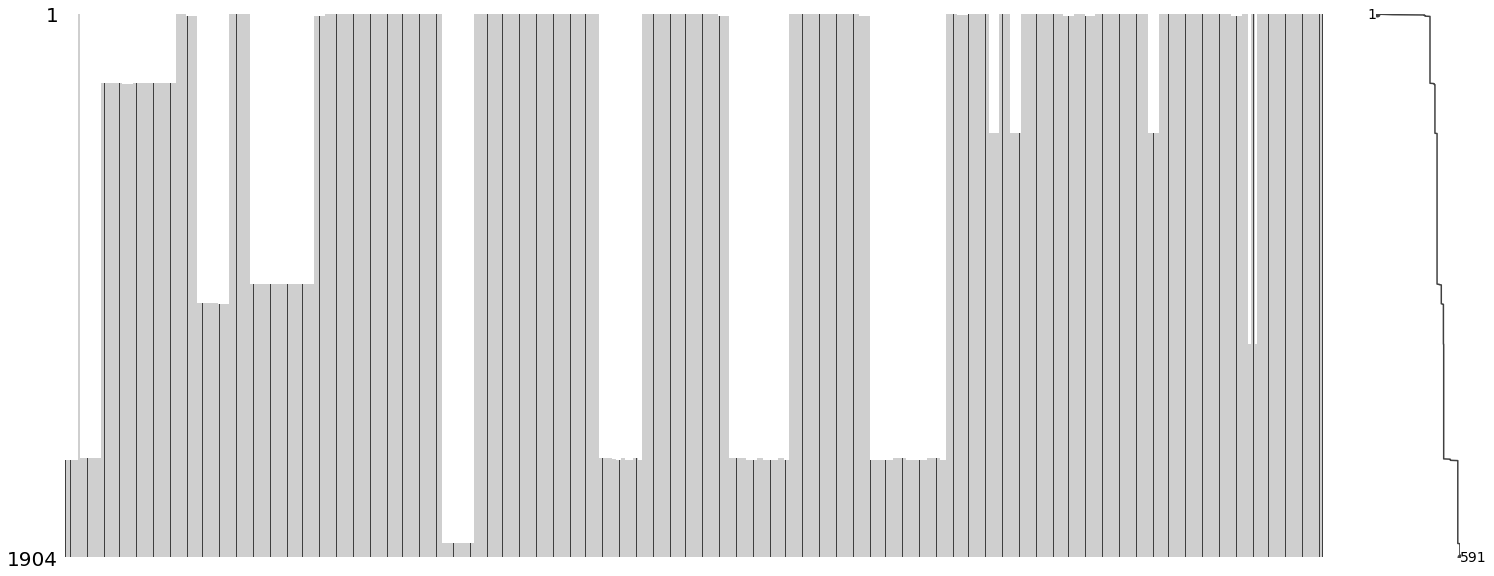

In [8]:
# Count columns and rows that are missing values
print(len(df.columns[df.isna().any()].tolist()),"of", len(df.columns),"columns that have at least one NaN value" )
print(df.isnull().any(axis=1).sum(), "of", df.any(axis=1).sum(), "rows have at least one NaN")

# Visualize the missing values (missing = white)
msno.matrix(df)

In [9]:
# Find the date range where the majority of datasets has values
# We'll print the counts for each value as a starting point for the feature. Because we cannot accurately back fill data we decide to limit our timeline to only the portion that contains data.
fvi = df.apply(pd.Series.first_valid_index)
print("Distinct values for the first valid index are:")
print(fvi.value_counts())

lvi = df.apply(pd.Series.last_valid_index)
print("\nDistinct values for the last valid index are:")
print(lvi.value_counts())

Distinct values for the first valid index are:
2015-01-02 00:00:00+00:00    223
2015-01-01 00:00:00+00:00     65
2020-11-20 00:00:00+00:00     52
2014-12-25 00:00:00+00:00     50
2020-11-13 00:00:00+00:00     46
2015-01-09 00:00:00+00:00     35
2015-11-30 00:00:00+00:00     25
2016-08-01 00:00:00+00:00     15
2018-08-01 00:00:00+00:00     15
2018-08-03 00:00:00+00:00     15
2022-01-05 00:00:00+00:00     15
2018-11-01 00:00:00+00:00     10
2015-01-06 00:00:00+00:00      5
2018-11-02 00:00:00+00:00      5
2015-12-04 00:00:00+00:00      5
2015-12-01 00:00:00+00:00      5
2020-11-18 00:00:00+00:00      2
2019-05-16 00:00:00+00:00      2
2000-09-27 00:00:00+00:00      1
dtype: int64

Distinct values for the last valid index are:
2022-04-05 00:00:00+00:00    591
dtype: int64


252 of 591 columns that have at least one NaN value
1851 of 1900 rows have at least one NaN


<AxesSubplot:>

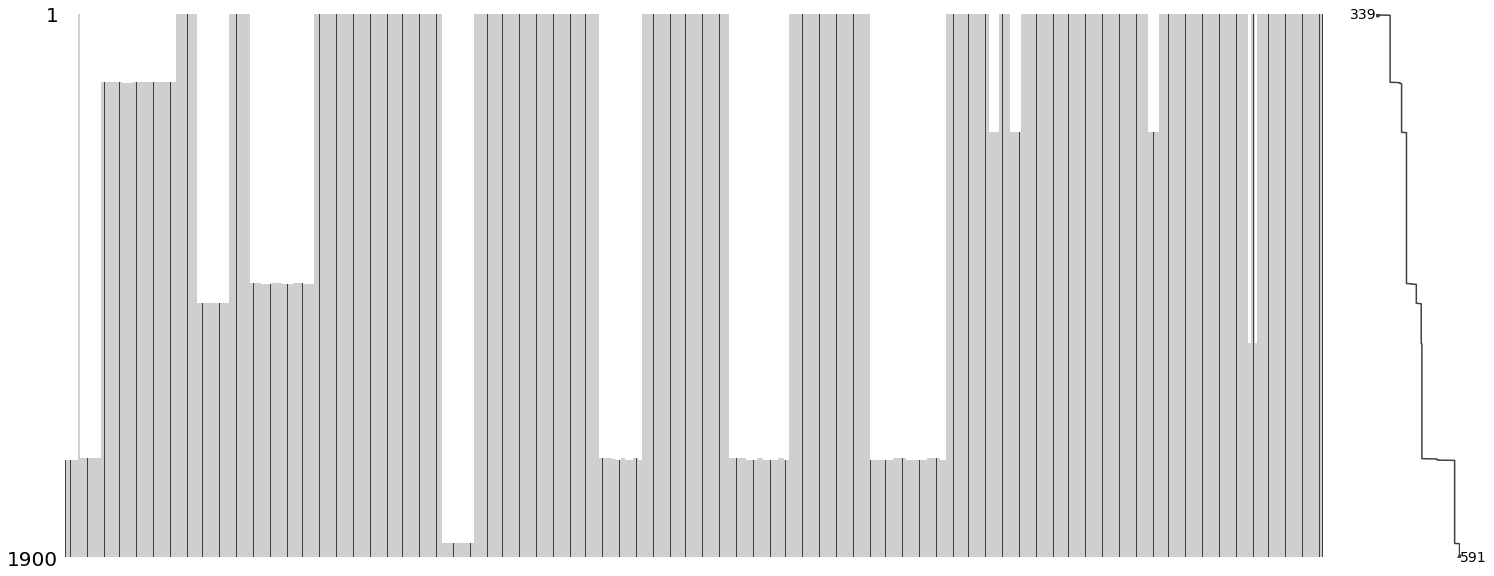

In [10]:
# Limit data set to start where most columns have data and end where most stop having data.
# This limits the amount of extrapolation needed in the final processing step
df = df[(df.index >= fvi.value_counts().idxmax()) & (df.index <= lvi.value_counts().idxmax())]

# Count columns and rows that are missing values
print(len(df.columns[df.isna().any()].tolist()),"of", len(df.columns),"columns that have at least one NaN value" )
print(df.isnull().any(axis=1).sum(), "of", df.any(axis=1).sum(), "rows have at least one NaN")

# Visualize missing values in the new dataset range
msno.matrix(df)

40 of 379 columns that have at least one NaN value
5 of 1900 rows have at least one NaN


<AxesSubplot:>

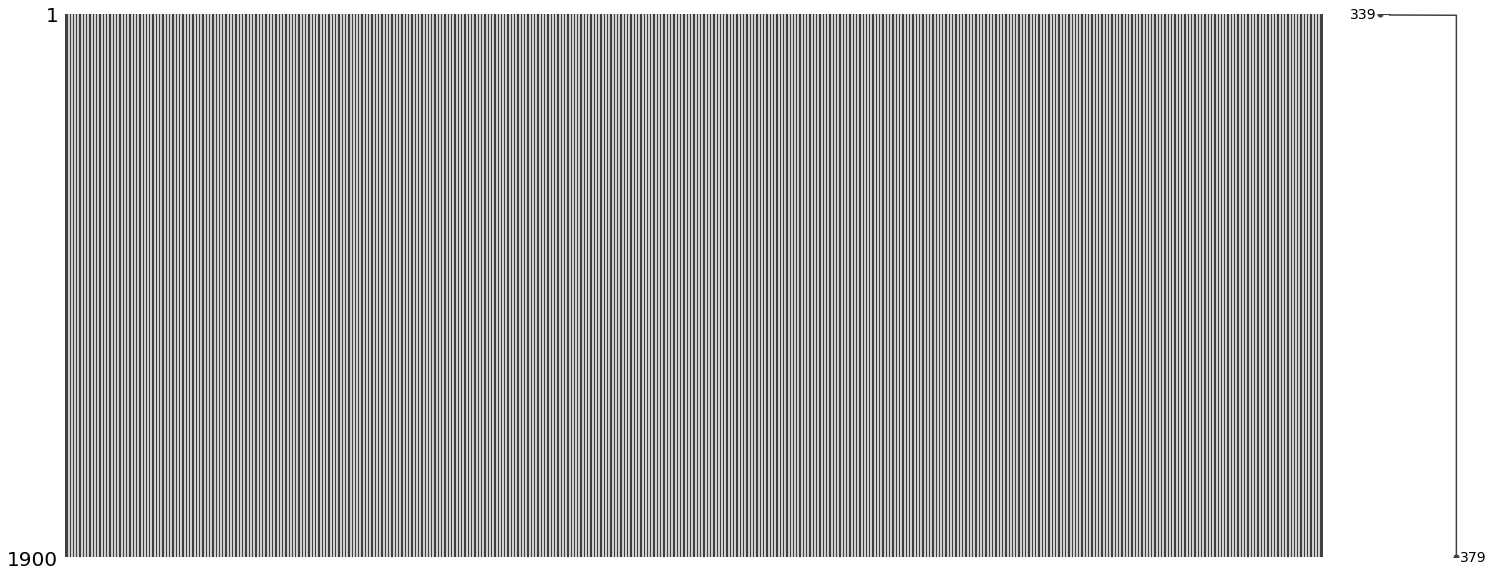

In [11]:
# Indescriminately remove columns if they have more than _threshold_ NaN values
threshold = 0.09 
df = df[df.columns[df.isnull().mean() < threshold]]

# Count columns and rows that are missing values
print(len(df.columns[df.isna().any()].tolist()),"of", len(df.columns),"columns that have at least one NaN value" )
print(df.isnull().any(axis=1).sum(), "of", df.any(axis=1).sum(), "rows have at least one NaN")

# Visualize dataset NaN values
msno.matrix(df)

40 columns have NaN values remaining. Their names are stored in nancols
40 of 379 columns that have at least one NaN value
5 of 1900 rows have at least one NaN


<AxesSubplot:>

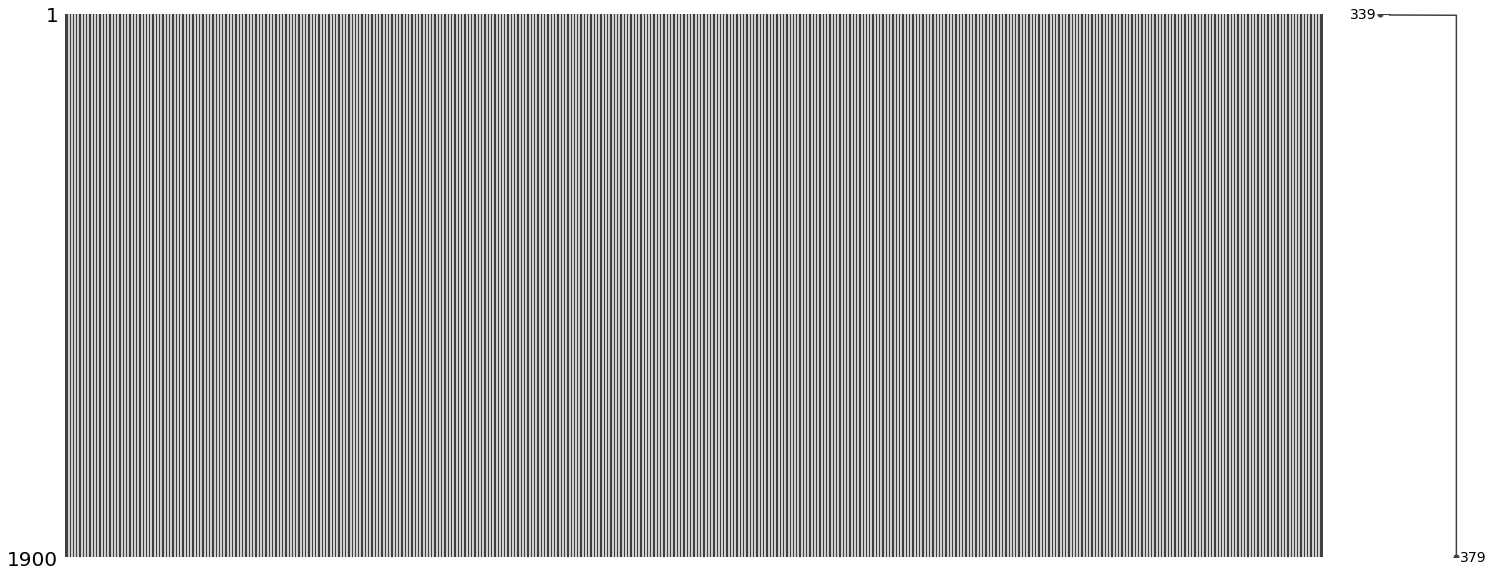

In [12]:
# Get column names that still have missing values, these are about to be extrapolated and we may need to refere back to what data was modified
nancols = df.columns[df.isna().any()].tolist()
print(len(nancols), "columns have NaN values remaining. Their names are stored in nancols")

# Extrapolate missing values using a second order spline (it should be accurate enough to predict values while retaining some naivity)
#df = df.interpolate(method='spline', order=2, limit_direction='forward') # Bad fit for ~6 features
#df = df.interpolate(method='spline', order=1, limit_direction='forward') # Bad fit for fewer than 2nd order Spline
#df = df.interpolate(method='pchip', limit_direction='forward') # Very bad fit
df = df.interpolate(method='ffill', limit_direction='forward') # Linear is the only method that will allow an extrapolation reliably

# Count columns and rows that are missing values
print(len(df.columns[df.isna().any()].tolist()),"of", len(df.columns),"columns that have at least one NaN value" )
print(df.isnull().any(axis=1).sum(), "of", df.any(axis=1).sum(), "rows have at least one NaN")

# Visualize missing values
msno.matrix(df)

In [13]:
# Validate that all features are fully populated
# All columns should have the same first and last indices

fvi = df.apply(pd.Series.first_valid_index)
print("Distinct values for the first valid index are:")
print(fvi.value_counts())

#Iteratively remove rows until all features contain data
while len(fvi.value_counts()) > 1:
    df = df[df.index >= fvi.value_counts().idxmin()]
    fvi = df.apply(pd.Series.first_valid_index)
    print("min value count idx", fvi.value_counts().idxmin())
    print("\nRe-processed values for the first valid index are:\n", fvi.value_counts())

lvi = df.apply(pd.Series.last_valid_index)
print("\nDistinct values for the last valid index are:")
print(lvi.value_counts())

Distinct values for the first valid index are:
2015-01-02 00:00:00+00:00    339
2015-01-09 00:00:00+00:00     35
2015-01-06 00:00:00+00:00      5
dtype: int64
min value count idx 2015-01-09 00:00:00+00:00

Re-processed values for the first valid index are:
 2015-01-06 00:00:00+00:00    344
2015-01-09 00:00:00+00:00     35
dtype: int64
min value count idx 2015-01-09 00:00:00+00:00

Re-processed values for the first valid index are:
 2015-01-09 00:00:00+00:00    379
dtype: int64

Distinct values for the last valid index are:
2022-04-05 00:00:00+00:00    379
dtype: int64


In [14]:
# Test for NaN, inf, or -inf values in dataframe

nan_vals = df.isna().sum().sum()
print('There are', nan_vals,'NaN in df')
inf_vals = df.isin([np.inf, -np.inf]).sum().sum()
print('There are',inf_vals,'inf or -inf values in df')

There are 0 NaN in df
There are 0 inf or -inf values in df


In [15]:
#df.info

#### 3.2 Lag Data

To perform Time Series (TS) analysis we shift our predictors vs our target. The function 'lagger' performs a lead on the prediction columns.

'lag_limit' columns are created for each Feature. Each column created is led by 'lag_delta' of the previous step. So lag_delta=1, lag_limit=2 would create a column pushed forward for 1 and 2 days. The allows us to fit the Target to the predictor values yesterday and the day before. Adjusting lag_delta=7, lag_limit=13 creates 3 months worth of weekly shifts so that we predict today's Target using 1, 2, 3, ... 13 week ago data. This will ultimately allow us to predict 3 months into the future using todays known Predcitor values.

In [16]:
df, odf = lagger(df, lag_delta=7, lag_limit=13)
# df = lagged columns in real values
# odf = original columns only, no lags

Original df shape: (1895, 379)
Lagged df shape (with NaN): (1895, 5306)
Lagged df shape (without NaN): (1804, 5306)
There are 0 NaN values remaining


dtale is an interactive Exploratory Data Analysis tool that prints a df as an 'excel-like' sheet which can be interacted with inside of a notebook

In [17]:
# Interactive EDA of Lagged Data
#d = dtale.show(df)
#d

In [18]:
# Verify that lagger didn't create any un-reconciled NaN, inf, or -inf values.
nan_vals = df.isna().sum().sum()
print('There are', nan_vals,'NaN in df')
inf_vals = df.isin([np.inf, -np.inf]).sum().sum()
print('There are',inf_vals,'inf or -inf values in df')

There are 0 NaN in df
There are 0 inf or -inf values in df


In [19]:
df.head(2)

,AUD/USD,Benzene CFR Taiwan MAvg (USD/MT)-AVERAGE,Benzene CFR Taiwan MAvg (USD/MT)-CLOSE,Benzene CFR Taiwan MAvg (USD/MT)-HIGH,Benzene CFR Taiwan MAvg (USD/MT)-HIGHLOW2,Benzene CFR Taiwan MAvg (USD/MT)-LOW,Benzene CFR Taiwan Weekly (USD/MT)-AVERAGE,Benzene CFR Taiwan Weekly (USD/MT)-CLOSE,Benzene CFR Taiwan Weekly (USD/MT)-HIGH,Benzene CFR Taiwan Weekly (USD/MT)-HIGHLOW2,...,"Xylenes (mixed)-Spot, Next Month, Low-N/A-Cents per Gallon-Houston, TX-North America_lag_28","Xylenes (mixed)-Spot, Next Month, Low-N/A-Cents per Gallon-Houston, TX-North America_lag_35","Xylenes (mixed)-Spot, Next Month, Low-N/A-Cents per Gallon-Houston, TX-North America_lag_42","Xylenes (mixed)-Spot, Next Month, Low-N/A-Cents per Gallon-Houston, TX-North America_lag_49","Xylenes (mixed)-Spot, Next Month, Low-N/A-Cents per Gallon-Houston, TX-North America_lag_56","Xylenes (mixed)-Spot, Next Month, Low-N/A-Cents per Gallon-Houston, TX-North America_lag_63","Xylenes (mixed)-Spot, Next Month, Low-N/A-Cents per Gallon-Houston, TX-North America_lag_70","Xylenes (mixed)-Spot, Next Month, Low-N/A-Cents per Gallon-Houston, TX-North America_lag_77","Xylenes (mixed)-Spot, Next Month, Low-N/A-Cents per Gallon-Houston, TX-North America_lag_84","Xylenes (mixed)-Spot, Next Month, Low-N/A-Cents per Gallon-Houston, TX-North America_lag_91"
date,,,,,,,,,,,,,,,,,,,,,
2015-05-14 00:00:00+00:00,0.8082,785.75,0.0,786.5,785.75,785.0,852.0,852.0,853.0,852.0,...,1795.2,1828.4,1931.2,1968.0,1887.6,1776.0,1652.8,1617.2,1502.4,1580.8
2015-05-15 00:00:00+00:00,0.8053,785.75,0.0,786.5,785.75,785.0,762.5,762.5,763.0,762.5,...,1795.2,1828.4,1931.2,1968.0,1887.6,1776.0,1652.8,1617.2,1502.4,1580.8


#### 3.3 Deal with non-Stationary Data

In [20]:

df , stat_test, df_orig_full = MakeStationaryLPC(df, AllCols=True, calcstat=False)
# df = pct_chage for all cols
# df_orig_full = original data


Performing Percent Change Calculation on all columns


In [21]:
nan_vals = df.isna().sum().sum()
print('There are', nan_vals,'NaN in df')
inf_vals = df.isin([np.inf, -np.inf]).sum().sum()
print('There are',inf_vals,'inf or -inf values in df')

df.head(2)

There are 0 NaN in df
There are 0 inf or -inf values in df


,AUD/USD,Benzene CFR Taiwan MAvg (USD/MT)-AVERAGE,Benzene CFR Taiwan MAvg (USD/MT)-CLOSE,Benzene CFR Taiwan MAvg (USD/MT)-HIGH,Benzene CFR Taiwan MAvg (USD/MT)-HIGHLOW2,Benzene CFR Taiwan MAvg (USD/MT)-LOW,Benzene CFR Taiwan Weekly (USD/MT)-AVERAGE,Benzene CFR Taiwan Weekly (USD/MT)-CLOSE,Benzene CFR Taiwan Weekly (USD/MT)-HIGH,Benzene CFR Taiwan Weekly (USD/MT)-HIGHLOW2,...,"Xylenes (mixed)-Spot, Next Month, Low-N/A-Cents per Gallon-Houston, TX-North America_lag_28","Xylenes (mixed)-Spot, Next Month, Low-N/A-Cents per Gallon-Houston, TX-North America_lag_35","Xylenes (mixed)-Spot, Next Month, Low-N/A-Cents per Gallon-Houston, TX-North America_lag_42","Xylenes (mixed)-Spot, Next Month, Low-N/A-Cents per Gallon-Houston, TX-North America_lag_49","Xylenes (mixed)-Spot, Next Month, Low-N/A-Cents per Gallon-Houston, TX-North America_lag_56","Xylenes (mixed)-Spot, Next Month, Low-N/A-Cents per Gallon-Houston, TX-North America_lag_63","Xylenes (mixed)-Spot, Next Month, Low-N/A-Cents per Gallon-Houston, TX-North America_lag_70","Xylenes (mixed)-Spot, Next Month, Low-N/A-Cents per Gallon-Houston, TX-North America_lag_77","Xylenes (mixed)-Spot, Next Month, Low-N/A-Cents per Gallon-Houston, TX-North America_lag_84","Xylenes (mixed)-Spot, Next Month, Low-N/A-Cents per Gallon-Houston, TX-North America_lag_91"
date,,,,,,,,,,,,,,,,,,,,,
2015-05-15 00:00:00+00:00,-0.003588,0.0,0.0,0.0,0.0,0.0,-0.105047,-0.105047,-0.10551,-0.105047,...,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0
2015-05-18 00:00:00+00:00,-0.006457,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,-0.174658,0.0,0.0,0.05518,0.0,0.0,0.015708,0.0


### 3.4 Visualize the data

In [22]:
# Visualize only the columns that had NaN values to be extrapolated
#multi_plot(df, title="Full Dataset Visualization")

### 3.5 Export Data

In [23]:
# Define default storage location for files
edataroot = '../../Data/Parquet/SKLearn Data/'

In [24]:
if os.path.isdir(edataroot):

    # Export Data
    df.to_parquet(path=edataroot+ifilename+'_for_modeling.parquet', engine='pyarrow', compression=None, index=True)
    print(ifilename+' dataset exported to ', edataroot+ifilename+'_for_modeling.parquet')

else:
    os.mkdir(edataroot)
    print('Storage location did not exist. It has been created\n')
    df.to_parquet(path=edataroot+ifilename+'_for_modeling.parquet', engine='pyarrow', compression=None, index=True)
    print(ifilename+' dataset exported to ', edataroot+ifilename+'_for_modeling.parquet')

combined_ffill dataset exported to  ../../Data/Parquet/SKLearn Data/combined_ffill_for_modeling.parquet


## 4.0 Modeling

### 4.1 Modeling configuration

#### 4.1.1 Scikit Learn Modeling Function

#### 4.1.2 Configure Global Model Inputs

In [25]:
# Simple utility to find a column name based on what it starts with
# May need it to find target column values

[col for col in df if col.startswith('Benzene-Spo')]

['Benzene-Spot, Current Month, High-N/A-Cents per Gallon-FOB Houston, TX-North America',
 'Benzene-Spot, Current Month, Low-N/A-Cents per Gallon-FOB Houston, TX-North America',
 'Benzene-Spot, Next Month, High-N/A-Cents per Gallon-FOB Houston, TX-North America',
 'Benzene-Spot, Next Month, Low-N/A-Cents per Gallon-FOB Houston, TX-North America',
 'Benzene-Spot, Current Month, High-N/A-Cents per Gallon-FOB Houston, TX-North America_lag_7',
 'Benzene-Spot, Current Month, High-N/A-Cents per Gallon-FOB Houston, TX-North America_lag_14',
 'Benzene-Spot, Current Month, High-N/A-Cents per Gallon-FOB Houston, TX-North America_lag_21',
 'Benzene-Spot, Current Month, High-N/A-Cents per Gallon-FOB Houston, TX-North America_lag_28',
 'Benzene-Spot, Current Month, High-N/A-Cents per Gallon-FOB Houston, TX-North America_lag_35',
 'Benzene-Spot, Current Month, High-N/A-Cents per Gallon-FOB Houston, TX-North America_lag_42',
 'Benzene-Spot, Current Month, High-N/A-Cents per Gallon-FOB Houston, TX-Nort

In [26]:
# Deal with inf and -inf values before train/test splitting
inf_vals = df.isin([np.inf, -np.inf]).sum().sum()
nan_vals = df.isna().sum().sum()
print('There are:',inf_vals,'inf or -inf values in df')
print('There are:',nan_vals,'NaN values in df')
if (inf_vals>0) or (nan_vals>0): 
    df = df.replace([np.inf, -np.inf], np.NaN)
    df = df.dropna(axis=0)
    inf_vals = df.isin([np.inf, -np.inf]).sum().sum()
    nan_vals = df.isna().sum().sum()
    print('After conversion there are:', inf_vals,'inf or -inf values in df')
    print('After conversion there are:',nan_vals,'NaN values in df')

There are: 0 inf or -inf values in df
There are: 0 NaN values in df


In [27]:
# Our target and Identifying columns won't change for any of the models so we'll define them once here
#target = 'Benzene-Spot, Current Month, High-N/A-Cents per Gallon-FOB Houston, TX-North America'
target = 'Benzene-Spot, Current Month, High-N/A-Cents per Gallon-FOB Houston, TX-North America'

# Our Identifying (IDcol) is 'date' for time series analyses
IDcol = ['date']

# All columns that are not Targets(predictee's) or ID's(dates) should be used to predict the Target
predictors = [x for x in df.columns if x not in [target]+[IDcol]]

print("Algorithm will attempt to predict:\n\t", target, "\nusing:\n\t", IDcol, "\nbased on:\n\t", len(predictors), "predictors")

Algorithm will attempt to predict:
	 Benzene-Spot, Current Month, High-N/A-Cents per Gallon-FOB Houston, TX-North America 
using:
	 ['date'] 
based on:
	 5305 predictors


#### 4.1.3 Extract prefered time frame

In [28]:
# Set start_date for slicing df
start_date = '2015-01-01'
# Set end_date for slicing df
end_date = '2019-12-31'

df_full = df.copy(deep=True)
df = df[start_date : end_date]

print('After processing:\ndf starts on:', df.index[0])
print('df ends on:  ', df.index[-1])

After processing:
df starts on: 2015-05-15 00:00:00+00:00
df ends on:   2019-12-31 00:00:00+00:00


#### 4.1.4 Create Train and Test Datasets

In [28]:
# ?Remove lags of column being predicted as they will not be valid prediction

In [29]:
# Print rows contained in original dataset for validation
print("The original dataset contains", df.any(axis=1).sum(), "rows")

# Define qsplit to handle the quantile split between train and test
qsplit = 0.60
rcnt = df.shape[0]
train_len = int(np.floor(rcnt*qsplit))
print(train_len, "values in training set for", qsplit,"% of data")
#test_len = rcnt-train_len

# Extract oldest 75% of rows to be used as training data
#train = df[df.index <= df.quantile(q=qsplit, axis=1).idxmax()].reset_index().rename_axis(None, axis=1)
train = df.iloc[:train_len,:]
train_orig = df_orig_full.iloc[:train_len, :]
print("The train dataset contains", train.any(axis=1).sum(), "rows or ", 100*train.shape[0]/rcnt, "% of data")
print('\tStarting on:', train.index[0],'\n\tEnding on:',train.index[-1])

# Extract newest 25% of rows to be used as testing data and remove the target column
#test = df[df.index > df.quantile(q=qsplit, axis=1).idxmax()].reset_index().rename_axis(None, axis=1)
test = df.iloc[train_len:, :]
test_orig = df_orig_full.iloc[train_len:, :]
print("The test dataset contains", test.any(axis=1).sum(), "rows or", 100*test.shape[0]/rcnt, "% of data")
print('\tStarting on:', test.index[0],'\n\tEnding on:',test.index[-1])
# Validate that all rows are accounted for in Train and test
if train.any(axis=1).sum() + test.any(axis=1).sum() == df.any(axis=1).sum():
    print("\nAll data accounted for in train and test. Sum of rows matches original df")
else:
    print("\nTrain/Test split incorrect. Sum of Train + Test does not match original df. Please verify before running models.")

The original dataset contains 1223 rows
733 values in training set for 0.6 % of data
The train dataset contains 733 rows or  59.93458708094849 % of data
	Starting on: 2015-05-15 00:00:00+00:00 
	Ending on: 2018-02-27 00:00:00+00:00
The test dataset contains 490 rows or 40.06541291905151 % of data
	Starting on: 2018-02-28 00:00:00+00:00 
	Ending on: 2019-12-31 00:00:00+00:00

All data accounted for in train and test. Sum of rows matches original df


### 4.2 Scikit Learn Modeling

#### 4.2.x Random Forest With Lag

In [30]:
# Make known test value dataframe
ktest = test[target]
# remove target from Testing
test = test.drop(columns=target)

In [31]:
ktest.head(5)

date
2018-02-28 00:00:00+00:00    0.000000
2018-03-01 00:00:00+00:00   -0.013205
2018-03-02 00:00:00+00:00    0.000000
2018-03-05 00:00:00+00:00    0.000000
2018-03-06 00:00:00+00:00    0.000000
Name: Benzene-Spot, Current Month, High-N/A-Cents per Gallon-FOB Houston, TX-North America, dtype: float64

In [32]:
# Define Algorithm for predition
alg = RandomForestRegressor()

# Model it
yhat, alg = modelfit(alg, train, test, ktest, predictors, target)


Training Report
RMSE : 0.002629

Testing Report
RMSE : 0.007709


In [33]:
coeffs = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
coeffs[0:20].sort_values(ascending=False)
#coeffs[0:20].sort_values(ascending=True).plot(kind='bar', title='Feature Importances')

Benzene-Spot, Current Month, Low-N/A-Cents per Gallon-FOB Houston, TX-North America                 0.453444
Benzene-Spot, Next Month, Low-N/A-Cents per Gallon-FOB Houston, TX-North America                    0.224670
Benzene-Spot, Next Month, High-N/A-Cents per Gallon-FOB Houston, TX-North America                   0.201501
USD/KRW                                                                                             0.002609
Solvent Naphtha FOB Rotterdam Weekly (USD/MT)-HIGHLOW2_lag_7                                        0.002424
Toluene-Spot, Current Month, Low-Commercial Grade-Cents per Gallon-FOB Houston, TX-North America    0.002061
Styrene CFR SE Asia Weekly (USD/MT)-CLOSE_lag_56                                                    0.001821
Benzene FOB Korea W2 (USD/MT)-HIGHLOW2_lag_7                                                        0.001811
Styrene CFR China H1 M2 LC 90 days (USD/MT)-HIGHLOW2_lag_7                                          0.001712
Styrene CFR SE Asia

Model only those columns that are lagged

In [34]:
# Generate list of columns with _lag_ in their titles
lagged_columns = [col for col in df.columns if '_lag_' in col]
lagged_columns.append(str(target))
# Subset training data for only lagged_columns
train_lagged = train[lagged_columns]

# Subset testing data for only lagged_columns
test_lagged = test[lagged_columns]

# Generate list of predotors for _lag_ only df
predictors2 = [x for x in train_lagged.columns if x not in [target]+[IDcol]]

In [35]:
# Model the lagged columns
alg2 = RandomForestRegressor()
yhat_lagged, alg_lagged = modelfit(alg2, train_lagged, test_lagged, ktest, predictors2, target)


Training Report
RMSE : 0.008001

Testing Report
RMSE : 0.02121


In [36]:
coeffs2 = pd.Series(alg_lagged.feature_importances_, predictors2).sort_values(ascending=False)
coeffs2[0:20].sort_values(ascending=False)

Styrene-Spot, Current Month, High-N/A-Cents per Pound-FOB Houston, TX-North America_lag_56                                                                         0.063821
Ethylene-Prod Cash Cost Propane Feed, Current Month, Spot Co-Product Credits-N/A-Cents per Pound-US Gulf Coast-North America_lag_56                                0.045942
Ethylene-Spot, Next Month, High-N/A-Cents per Pound-Delivered Pipeline, Gulf Coast-North America_lag_35                                                            0.030256
Ethylene-Prod Cash Cost Purity Ethane Feed, Current Month, Spot Co-Product Credits-N/A-Cents per Pound-US Gulf Coast-North America_lag_35                          0.017116
Ethylene-Spot, Current Month, Low-N/A-Cents per Pound-Delivered Pipeline, Gulf Coast-North America_lag_91                                                          0.016738
Ethylene-Spot, Current Month, High-N/A-Cents per Pound-Delivered Pipeline, Gulf Coast-North America_lag_35                                  

In [55]:
#pred = unPCall(test_orig, yhat)

In [ ]:
#pred.head(5)

In [ ]:
#test_orig.iloc[[0]]

In [ ]:
# Predict Testing Data
#pred['orig'] = test_orig[target]

In [ ]:
#fig = px.line(pred, x = pred.index, y=[pred[target], pred['orig']])#, labels=['Predicted','Known'])
#fig
#fig.add_scatter(x=ktest.index, y=ktest)

#### 4.2.y Step Forward Validation 

##### 4.2.y.1 Utilizing functions in SciKit to perform walk forward validation

In [40]:
# Resample df to only 1 value per week (default is Sunday but doesn't matter and should ensure an aggregate of every week is accurate)
wdf = df.resample('w').mean()
wtrain = wdf[predictors]
wtarget = wdf[target]

In [41]:
iw = 13*3 # Initial window = 9 months ensures some data for longest forecast
sl = 1 # Step Length = 1 to take 1 week steps into the future
forecast_horizon = 13 # forecasting 13 weeks into the future

cv = ExpandingWindowSplitter(initial_window=iw, fh=forecast_horizon, step_length=sl)

n_splits = cv.get_n_splits(wdf)
print(f"Number of Folds = {n_splits}")

Number of Folds = 192


In [96]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 3)] # num = 10
# Number of features to consider at every split
max_features = ['auto', 'sqrt'] #
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 3)] # num=11
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 10] # [2, 5,]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4] # 1, 
# Method of selecting samples for training each tree
bootstrap = [True, False] # 

# Define Random Forest Regressor HP grid for DV
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rg_str = '<br>&nbsp; n_estimators:'+ str(n_estimators) + \
               '<br>&nbsp; max_features: '+ str(max_features) +\
               '<br>&nbsp; max_depth: ;'+ str(max_depth) + \
               '<br>&nbsp; min_samples_split: '+ str(min_samples_split) + \
               '<br>&nbsp; min_samples_leaf: '+ str(min_samples_leaf) + \
               '<br>&nbsp; bootstrap: '+ str(bootstrap)

print(random_grid)
#print(rg_str)

{'n_estimators': [200, 1100, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 60, 110, None], 'min_samples_split': [2, 10], 'min_samples_leaf': [2, 4], 'bootstrap': [True, False]}


In [97]:
alg = RandomForestRegressor()
#rf_random = RandomizedSearchCV(estimator = alg, param_distributions = random_grid, n_iter = 100, cv = cv, verbose=2, random_state=42, n_jobs = -1)
rf_random = RandomizedSearchCV(estimator = alg, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1, scoring='neg_mean_absolute_error') #cv=3 , n_iter=100

In [98]:
fit_out = rf_random.fit(wtrain, wtarget)

print(abs(fit_out.best_score_))

print(fit_out.best_params_)

# When the search finishes send us a message
payload = {
    "text": "Grid search complete. <br><br> Best Score:<br>&nbsp;&nbsp;" + str(abs(fit_out.best_score_)) + "<br><br>Best Params:<br>" + str(fit_out.best_params_).replace(',',',<br>&nbsp;&nbsp;') + \
        '<br><br>Grid Search Params:' + rg_str
}
headers = {
    'Content-Type': 'application/json'
}
response = requests.post(url, headers=headers, data=json.dumps(payload))
print(response.text.encode('utf8'))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


##### 4.2.y.2 DIY Walkforward validation (before I knew about sklearn functions, incomplete)

General flow of what needs to be developed:
Flow:
- Shift Target by 1 (backward)
- Train between walk_start : initial_end - 1
- Pred = Predict initial_end (next 1 value dT value)
- Store PredValue at Shift = 1, Iteration = 1, Index = initial_end+1
- Store Alg at Shift = 1, Iteration = 1, Index = initial_end+1
- Shift Target by 2 
- Train between walk_start and initial_end - 2
- Pred = Predict initial_end[+1 : +2] (next 2 value dT values)
- Store 2 PredValue at Shift = 1, Iteration = 2, Index = initial_end[+1 : +2]
- Store Alg at Shift = 1, Iteration = 2, Index = initial_end[+1 : +2]
- Continue to n_pred_steps

Take inputs for:
- algorithm
- dtrain << Training data with all predictors and targets populated>>
- walk_start
- initial_end
- walk_end
- n_pred_steps = 13 (~3 months with weekly data)

Code Outline:
- dpred = dtrain[-1].index + 1 : dtrain[-1].index + 1 + n_pred_steps << provides the range of dates that will be stepped through>>
- for current_end in df[initial_end : walk_end]   << current_end = last training data point >>
    - for lagged_end in [current_end+1 : current_end + n_pred_steps]   << lagged_end = current data point being predicted by shifting model>>
      - alg.fit(walk_start : current_end)

In [231]:
# Loop logic that will append to a multi-index DF on each loop iteration
dfs = pd.DataFrame()
#df_labels = np.empty(0)
mones = pd.DataFrame(np.triu(np.ones([13,13]))).replace({0:np.nan})

for icnt in range(0,10):
    #print(icnt)
    tdf = mones.multiply(icnt)
    tdf = pd.concat([tdf], keys=[icnt], names=['Shift', 'Iteration'], axis=1)
    dfs = pd.concat([dfs, tdf], axis=1) #, keys=[icnt], names=['DF', 'Iteration']


#dfs[[1]]
#dfs


Resample the training data to provide weekly values

In [271]:
# Resample training data for weekly values: 
wtrain = train.resample('w').mean()
wtrain = wtrain['05-01-2015' : '12-31-2015']

33

Framework the function before coding it as such to do the lag-predict at each shift interval

In [301]:
# Variables needed in the future?
walk_end = '2016-03-31'

# Define where we want to start and end our walk forward
ws = '2015-05-15'
ie = '2015-12-31'
steps = 13


def ShiftModel(alg, df, n_pred_steps, target, verbose = True): # , train_end
    """
    ShiftModel performs model and predict for a given number of prediction steps
    OUTPUT:
        preds = dataframe of predictions with L0 index that is first predicted week index
    INPUT:
        alg = SKLearn algorithm called to model and predict
        df = dataframe of training data. Dates must be equally spaced. Prediction will use the df[-2:-1] spacing
        train_end = DT index value to stop training at
        n_pred_steps = number of date increments to forecast into the future
        target = column name which is being predicted
        verbose = controls printing during execution
    """
    # Get list of columns which will be shifted. These columns are also the Predictor columns
    scols = [col for col in df if col != target]

    # Calculate delta(df) to be used for prediction values
    dT = df.index[-1] - df.index[-2]
    if verbose: print('Prediction increment will be:', dT)

    # Pre assemble the prediction dataframe
    preds = pd.DataFrame()
    preds.index = pd.date_range(wtrain.index[-1]+dT, periods=n_pred_steps, freq=dT)
    
    if verbose: print('Forcasting:', preds.index[0])
    # Loop modeling and prediciton 
    for lcnt in range(1, len(preds)+1):
        if verbose: print('\t to', preds.index[lcnt], end='\r')
        # Shift original data for modeling and prediction
        sdf = wtrain[scols].shift(lcnt).dropna(axis=0)
        #alg.fit(sdf[scols], sdf[target])
        #print('lcnt',lcnt,'with len of sdf is', len(sdf),'from',sdf.index[0],'to',sdf.index[-1])
        

In [303]:
ShiftModel(alg, wtrain, 13, target)

Prediction increment will be: 7 days 00:00:00
Forcasting: 2016-01-03 00:00:00+00:00
lcnt 1 with len of sdf is 32 from 2015-05-24 00:00:00+00:00 to 2015-12-27 00:00:00+00:00
lcnt 2 with len of sdf is 31 from 2015-05-31 00:00:00+00:00 to 2015-12-27 00:00:00+00:00
lcnt 3 with len of sdf is 30 from 2015-06-07 00:00:00+00:00 to 2015-12-27 00:00:00+00:00
lcnt 4 with len of sdf is 29 from 2015-06-14 00:00:00+00:00 to 2015-12-27 00:00:00+00:00
lcnt 5 with len of sdf is 28 from 2015-06-21 00:00:00+00:00 to 2015-12-27 00:00:00+00:00
lcnt 6 with len of sdf is 27 from 2015-06-28 00:00:00+00:00 to 2015-12-27 00:00:00+00:00
lcnt 7 with len of sdf is 26 from 2015-07-05 00:00:00+00:00 to 2015-12-27 00:00:00+00:00
lcnt 8 with len of sdf is 25 from 2015-07-12 00:00:00+00:00 to 2015-12-27 00:00:00+00:00
lcnt 9 with len of sdf is 24 from 2015-07-19 00:00:00+00:00 to 2015-12-27 00:00:00+00:00
lcnt 10 with len of sdf is 23 from 2015-07-26 00:00:00+00:00 to 2015-12-27 00:00:00+00:00
lcnt 11 with len of sdf i

#### 4.2.x Prophet + Random Forest
Utilizing the Facebook Prophet algorithm we can perform univariate predictor forecasting into the future. Using these forecasted predictor values we can then apply our SKLearn prediction on the Target value.

In [ ]:
#alg = RandomForestRegressor()
#datafolder = dataroot+'FitOutputs/'
#filename = str(alg)

#fdf, fdfu, fdfl, coefs = prophet_scikit(alg, df, train, test, pdates, predictors, target, datafolder, filename)

#print('\n*****************************')
#print('** Top feature importances **')
#print('*****************************')
#print(coefs[0:10].sort_values(by='Importance', ascending=False))

######
# Save is not currently active in the function file #
######

In [ ]:
#multi_plot(fdf, "Future Plot (Average)")

# Documentation and Links

#### SKTime Documentation:
* https://www.sktime.org/en/latest/examples/01_forecasting.html

#### SKforcast (PIP, not installed in environment):
* https://www.cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html

#### Incremental Forecast loop using standard sklearn algorithms:
* https://www.analyticsvidhya.com/blog/2021/06/random-forest-for-time-series-forecasting/
* https://towardsdatascience.com/time-series-modeling-using-scikit-pandas-and-numpy-682e3b8db8d1
* https://www.ethanrosenthal.com/2019/02/18/time-series-for-scikit-learn-people-part3/

#### TS with Random Forest
* https://towardsdatascience.com/multivariate-time-series-forecasting-using-random-forest-2372f3ecbad1

#### ARIMA
* https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

#### Prophet 
* https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3